In [6]:
#Import necessary packages and set options for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [8]:
def scatter(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(14,6))
    plt.scatter(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#### Functions

In [9]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [10]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [11]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Collect Stock Data

In [12]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


##### ARIMA

In [13]:
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [14]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [15]:
def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

In [30]:
def plot_seasonal_decomposition(data, period):
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ARIMA Modeling
ARIMA Modeling is a common technique in time series forecasting where historical data is used to predict the movement of future data. In the case of stock investment, when you are using historical stock data you are able to understand potential trends within the data before implementing a forecast.

## Sector ETF and Time Period Setup

In [16]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [17]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [18]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [19]:
# adjusted close price dataframe
adj_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

## ARIMA

ARIMA can use pcf or acf to breakdown the data manually or automatically.

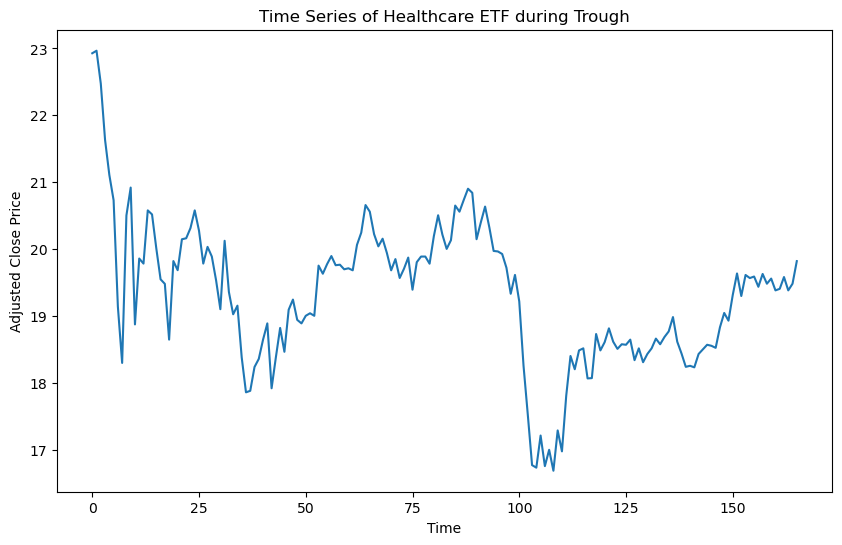

In [28]:
time_series(np.arange(len(adj_close_sector_etf['trough']['XLV'])),adj_close_sector_etf['trough']['XLV'],'Time Series of Healthcare ETF during Trough','Time','Adjusted Close Price')

In [22]:
adf_test(adj_close_sector_etf['trough']['XLV'])

ADF Statistic:  -3.9457281393033465
P-Value:  0.0017229336692211389
Critical Value: 
	1%: -3.47
	5%: -2.88
	10%: -2.58


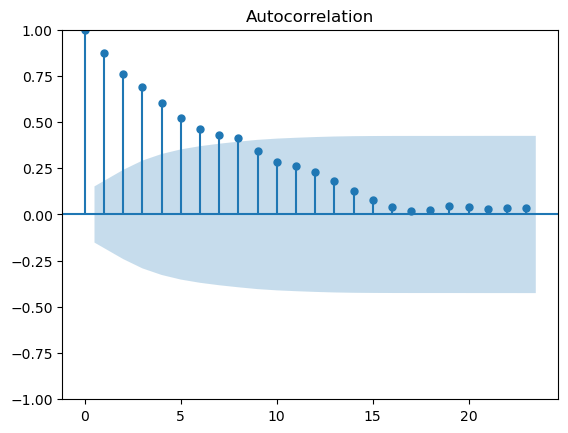

In [25]:
acf_trough_xlv = plot_acf(adj_close_sector_etf['trough']['XLV'])

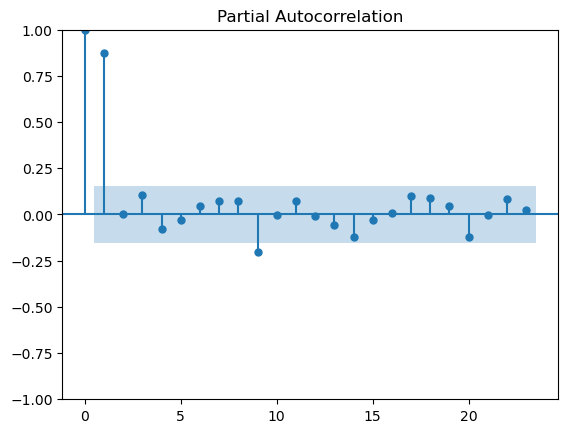

In [26]:
pacf_trough_xlv = plot_pacf(adj_close_sector_etf['trough']['XLV'])


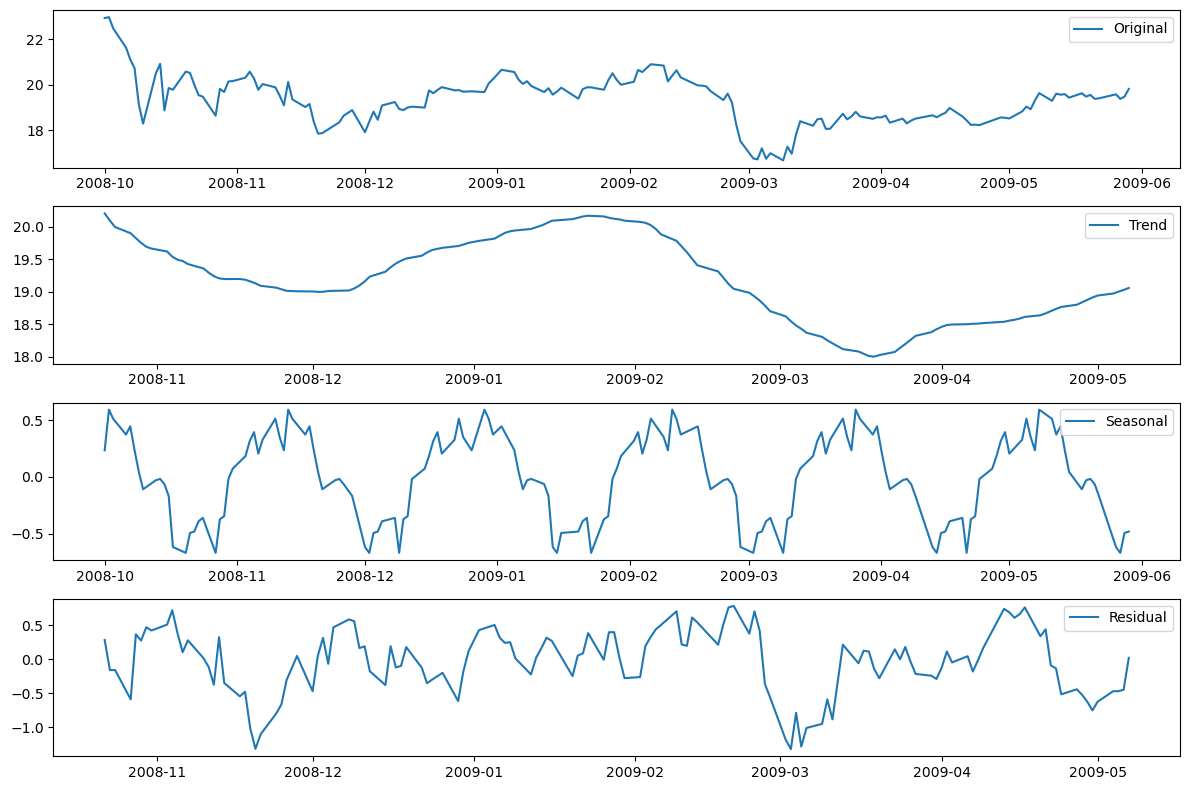

In [36]:
plot_seasonal_decomposition(adj_close_sector_etf['trough']['XLV'],30)

In [41]:
evaluate_time_series_models(adj_close_sector_etf['trough']['XLV'].iloc[:-5],[0,1,2,3,4,5],[0,1,2,3,4,5],[0,1,2])

,Model,Order,AIC,BIC
76,ARIMA,"(1, 1, 4)",206.390947,224.841990
108,ARIMA,"(3, 1, 0)",206.716105,219.016800
90,ARIMA,"(2, 1, 0)",207.115486,216.341007
127,ARIMA,"(4, 1, 1)",207.234280,225.685323
57,ARIMA,"(0, 1, 3)",207.773071,220.073766
...,...,...,...,...
49,ARIMA,"(0, 0, 1)",352.243407,361.487620
48,ARIMA,"(0, 0, 0)",484.106690,490.269499
6,MA,"(0, 0, 0)",484.106690,490.269499
12,ARMA,"(0, 0, 0)",484.106690,490.269499


In [42]:
model = ARIMA(adj_close_sector_etf['trough']['XLV'].iloc[:-5], order=(1, 1, 4))
model_fit = model.fit()

# Forecast prices
forecast = model_fit.forecast(steps=5)

/Users/ben_nicholson/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


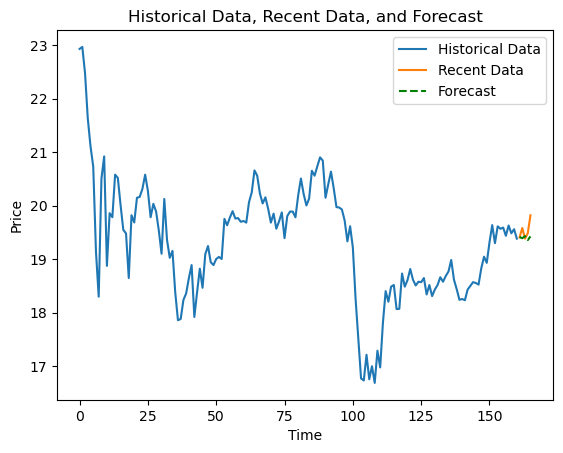

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Plot historical data up to the last 5 points
plt.plot(np.arange(len(adj_close_sector_etf['trough']['XLV'].iloc[:-5])), 
         adj_close_sector_etf['trough']['XLV'].iloc[:-5], label="Historical Data")

# Plot the last 5 points of the actual data
plt.plot(np.arange(len(adj_close_sector_etf['trough']['XLV']) - 5, len(adj_close_sector_etf['trough']['XLV'])), 
         adj_close_sector_etf['trough']['XLV'].iloc[-5:], label="Recent Data")

plt.plot(forecast, label="Forecast", linestyle="--", color="green")

# Add labels, legend, and title
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Historical Data, Recent Data, and Forecast")
plt.legend()
plt.show()

In [43]:
print(forecast)

161    19.412192
162    19.389655
163    19.429100
164    19.354655
165    19.423150
Name: predicted_mean, dtype: float64
